# Final project!!!
I'm employed by an online store that sells household goods. I've recieved a single database with all recorded transaction history. We'd like to pinpoint factors affecting the purchases in the store. For doing so I'll analyze the purchases history emphasising the items' description.

In [1]:
import pandas as pd
import numpy as np
! python -m pip install sidetable
from scipy.stats import spearmanr
import sidetable 
from scipy import stats as st
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")
! python -m pip install plotly
import plotly.express as px
from plotly import graph_objects as go 
from pylab import *
import re
import math as mth
from nltk import tokenize
import nltk
nltk.download('punkt')
! python -m pip install pymystem3
from pymystem3 import Mystem
from collections import Counter
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
from pylab import rcParams
from sklearn.preprocessing import StandardScaler
!pip install -U scikit-learn
import sklearn.cluster
from sklearn.cluster import KMeans
from PIL import Image
! pip install wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import plotly.offline as pyoff
from scipy.spatial.distance import cdist
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Joni\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Joni\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
try:
    data = pd.read_csv('ecommerce_dataset_us.csv',sep = '\t')
except:
    data = pd.read_csv('/datasets/ecommerce_dataset_us.csv',sep = '\t')

Loading all dataset to DF data

In [3]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,11/29/2018 08:26,2.55,17850.0
1,536365,71053,WHITE METAL LANTERN,6,11/29/2018 08:26,3.39,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,11/29/2018 08:26,2.75,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,11/29/2018 08:26,3.39,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,11/29/2018 08:26,3.39,17850.0


data contains column InvoiceNo (the number allocated for each invoice), StockCode (code for each item), Description (description of each item), Quantity (number of units purchased of each product), InvoiceDate (the date of purchase), UnitPrice (price per unit), CustomerID (individual ID for each customer).

In [4]:
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 28.9+ MB


,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


InvoiceNo seems to be an object instead of an integer. Will look into that. InvoiceDate should be changed to Datetime type. CustumerID will be nicer and more compact as and integer instead of a float. Some missing descriptions can be spotted as well as Custumer's IDs.

In [5]:
data.stb.missing(style=True)

,missing,total,percent
CustomerID,"135,080","541,909",24.93%
Description,"1,454","541,909",0.27%
InvoiceNo,0,"541,909",0.00%
StockCode,0,"541,909",0.00%
Quantity,0,"541,909",0.00%
InvoiceDate,0,"541,909",0.00%
UnitPrice,0,"541,909",0.00%


In [6]:
for column_name in data.columns:
    column = data[column_name] 
    count = (column == 0).sum()
    print('Count of zeros in column ', column_name, ' is : ', (count / len(column))*100, '%')
print()   
print('unique cases in each column:')
for col in data:
    print(col, data[col].unique())

Count of zeros in column  InvoiceNo  is :  0.0 %
Count of zeros in column  StockCode  is :  0.0 %
Count of zeros in column  Description  is :  0.0 %
Count of zeros in column  Quantity  is :  0.0 %
Count of zeros in column  InvoiceDate  is :  0.0 %
Count of zeros in column  UnitPrice  is :  0.4641000610803659 %
Count of zeros in column  CustomerID  is :  0.0 %

unique cases in each column:
InvoiceNo ['536365' '536366' '536367' ... '581585' '581586' '581587']
StockCode ['85123A' '71053' '84406B' ... '90214U' '47591b' '23843']
Description ['WHITE HANGING HEART T-LIGHT HOLDER' 'WHITE METAL LANTERN'
 'CREAM CUPID HEARTS COAT HANGER' ... 'lost'
 'CREAM HANGING HEART T-LIGHT HOLDER' 'PAPER CRAFT , LITTLE BIRDIE']
Quantity [     6      8      2     32      3      4     24     12     48     18
     20     36     80     64     10    120     96     23      5      1
     -1     50     40    100    192    432    144    288    -12    -24
     16      9    128     25     30     28      7     56     7

Can see that some UnitPrices are 0. Doesn't offer a lot of help conducting transaction analysis. Luckily it's only 0.46% and I'm not the store manager, so can remove them later without commiting a froud.

In [7]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], format="%m/%d/%Y %H:%M")

In [8]:
data['CustomerID'] = data.groupby('InvoiceNo')['CustomerID'].ffill().bfill()

Estimating and replacing customer IDs according to invoice numbers. Safe to assume these should correlate, since an invoice is for a specific costumer.

In [9]:
data.stb.missing(style=True)

,missing,total,percent
Description,"1,454","541,909",0.27%
InvoiceNo,0,"541,909",0.00%
StockCode,0,"541,909",0.00%
Quantity,0,"541,909",0.00%
InvoiceDate,0,"541,909",0.00%
UnitPrice,0,"541,909",0.00%
CustomerID,0,"541,909",0.00%


After some changes only 0.27% of the Description column is missing.

In [10]:
data['CustomerID'] = data['CustomerID'].astype(int)

Changing dtype for CustumerID column to integer.

In [11]:
data[data['Description'].isnull()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
622,536414,22139,NaN,56,2018-11-29 11:52:00,0.0,12838
1970,536545,21134,NaN,1,2018-11-29 14:32:00,0.0,12472
1971,536546,22145,NaN,1,2018-11-29 14:33:00,0.0,12472
1972,536547,37509,NaN,1,2018-11-29 14:33:00,0.0,12472
1987,536549,85226A,NaN,1,2018-11-29 14:34:00,0.0,17346
...,...,...,...,...,...,...,...
535322,581199,84581,NaN,-2,2019-12-05 18:26:00,0.0,14251
535326,581203,23406,NaN,15,2019-12-05 18:31:00,0.0,14251
535332,581209,21620,NaN,6,2019-12-05 18:35:00,0.0,14251
536981,581234,72817,NaN,27,2019-12-06 10:33:00,0.0,15950


All the rows containing null in Description column. Can't spot commonality between them.

In [12]:
data['Description']=data['Description'].fillna('Unknown') 

Changing all unknown values in description column to 'Unknown'

In [13]:
data.stb.missing(style=True)

,missing,total,percent
InvoiceNo,0,"541,909",0.00%
StockCode,0,"541,909",0.00%
Description,0,"541,909",0.00%
Quantity,0,"541,909",0.00%
InvoiceDate,0,"541,909",0.00%
UnitPrice,0,"541,909",0.00%
CustomerID,0,"541,909",0.00%


In [14]:
print('Percentage of duplicates in dataset: ', data.duplicated().sum()/len(data)*100, '%')

Percentage of duplicates in dataset:  0.9721189350979592 %


Less than 1% of duplicated rows. Will removed them later peacefully.

In [15]:
duplicate = data[data.duplicated()]
duplicate

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2018-11-29 11:45:00,1.25,17908
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2018-11-29 11:45:00,2.10,17908
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2018-11-29 11:45:00,2.95,17908
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2018-11-29 11:45:00,4.95,17908
555,536412,22327,ROUND SNACK BOXES SET OF 4 SKULLS,1,2018-11-29 11:49:00,2.95,17920
...,...,...,...,...,...,...,...
541675,581538,22068,BLACK PIRATE TREASURE CHEST,1,2019-12-07 11:34:00,0.39,14446
541689,581538,23318,BOX OF 6 MINI VINTAGE CRACKERS,1,2019-12-07 11:34:00,2.49,14446
541692,581538,22992,REVOLVER WOODEN RULER,1,2019-12-07 11:34:00,1.95,14446
541699,581538,22694,WICKER STAR,1,2019-12-07 11:34:00,2.10,14446


In [16]:
duplicate = data[data.duplicated(subset=['InvoiceNo', 'CustomerID', 'Description'], keep=False)]
duplicate

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
113,536381,71270,PHOTO CLIP LINE,1,2018-11-29 09:41:00,1.25,15311
125,536381,71270,PHOTO CLIP LINE,3,2018-11-29 09:41:00,1.25,15311
483,536409,90199C,5 STRAND GLASS NECKLACE CRYSTAL,3,2018-11-29 11:45:00,6.35,17908
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2018-11-29 11:45:00,4.95,17908
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2018-11-29 11:45:00,2.10,17908
...,...,...,...,...,...,...,...
541692,581538,22992,REVOLVER WOODEN RULER,1,2019-12-07 11:34:00,1.95,14446
541697,581538,21194,PINK HONEYCOMB PAPER FAN,1,2019-12-07 11:34:00,0.65,14446
541698,581538,35004B,SET OF 3 BLACK FLYING DUCKS,1,2019-12-07 11:34:00,5.45,14446
541699,581538,22694,WICKER STAR,1,2019-12-07 11:34:00,2.10,14446


Since many of these are off the same customer and invoice number, good estimation would be that they were accidental double types.

In [17]:
data.drop_duplicates(keep='first', inplace=True)

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 536641 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    536641 non-null  object        
 1   StockCode    536641 non-null  object        
 2   Description  536641 non-null  object        
 3   Quantity     536641 non-null  int64         
 4   InvoiceDate  536641 non-null  datetime64[ns]
 5   UnitPrice    536641 non-null  float64       
 6   CustomerID   536641 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), object(3)
memory usage: 30.7+ MB


No more missing values. All columns are in the correct type

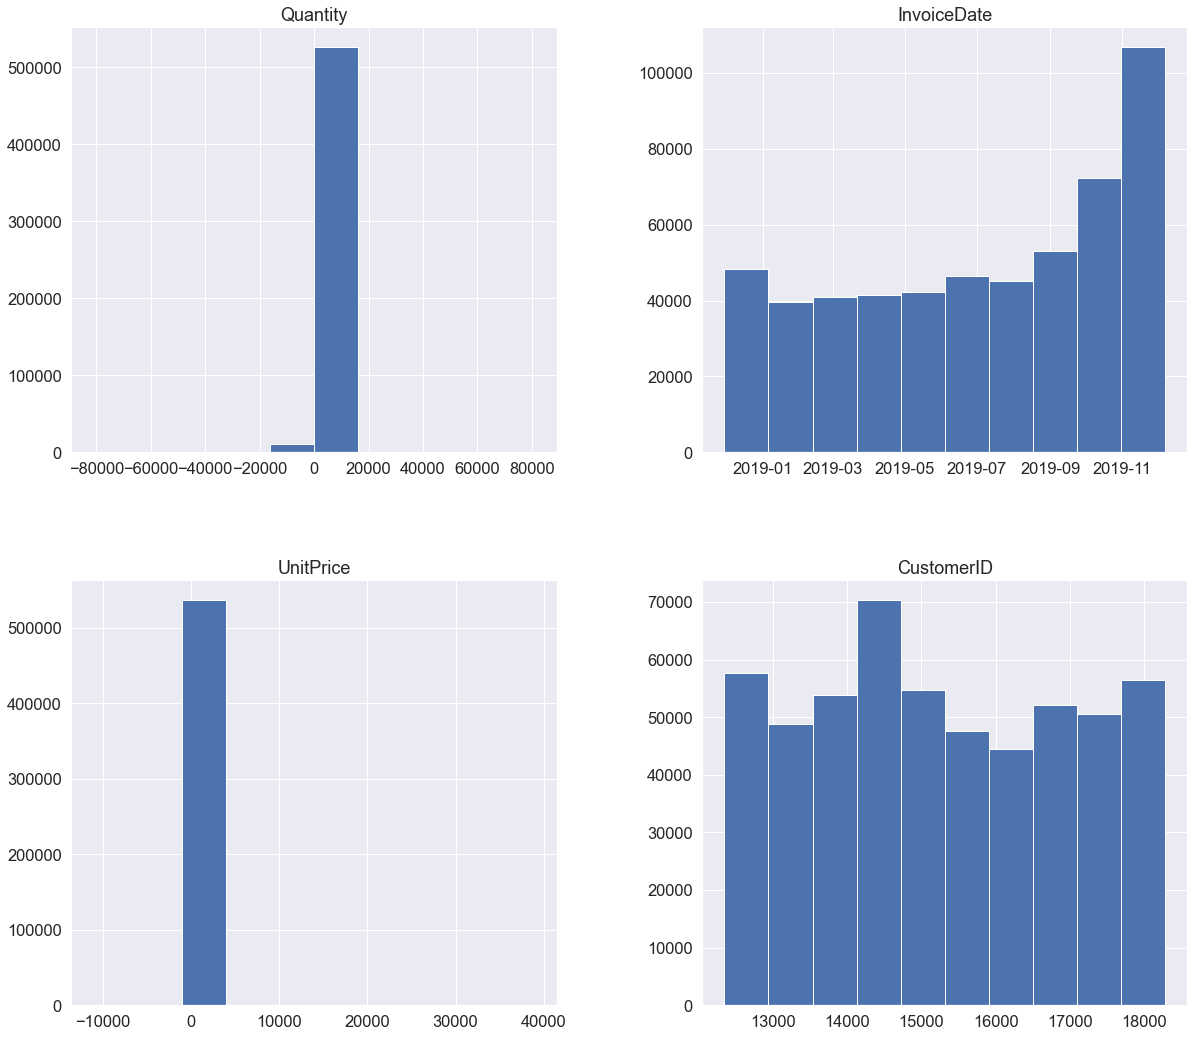

In [19]:
sns.set(rc = {'figure.figsize':(20,18)}, font_scale = 1.5)
data.hist()
plt.show()

Found out in the histograms that there's still some rows where UnitPrice and Quantity is bellow 0. Shall be investigate that

In [20]:
odd_items = data[(data['UnitPrice'] <= 0) | (data['Quantity'] <= 0)]
print('Number of odd logs with price and/or quantity of 0 or less: ', odd_items.count()[1])
odd_items

Number of odd logs with price and/or quantity of 0 or less:  11763


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
141,C536379,D,Discount,-1,2018-11-29 09:41:00,27.50,14527
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2018-11-29 09:49:00,4.65,15311
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2018-11-29 10:24:00,1.65,17548
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2018-11-29 10:24:00,0.29,17548
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2018-11-29 10:24:00,0.29,17548
...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2019-12-07 09:57:00,0.83,14397
541541,C581499,M,Manual,-1,2019-12-07 10:28:00,224.69,15498
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2019-12-07 11:57:00,10.95,15311
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2019-12-07 11:58:00,1.25,17315


Can see that these cases have odd StockCodes and some odd descriptions

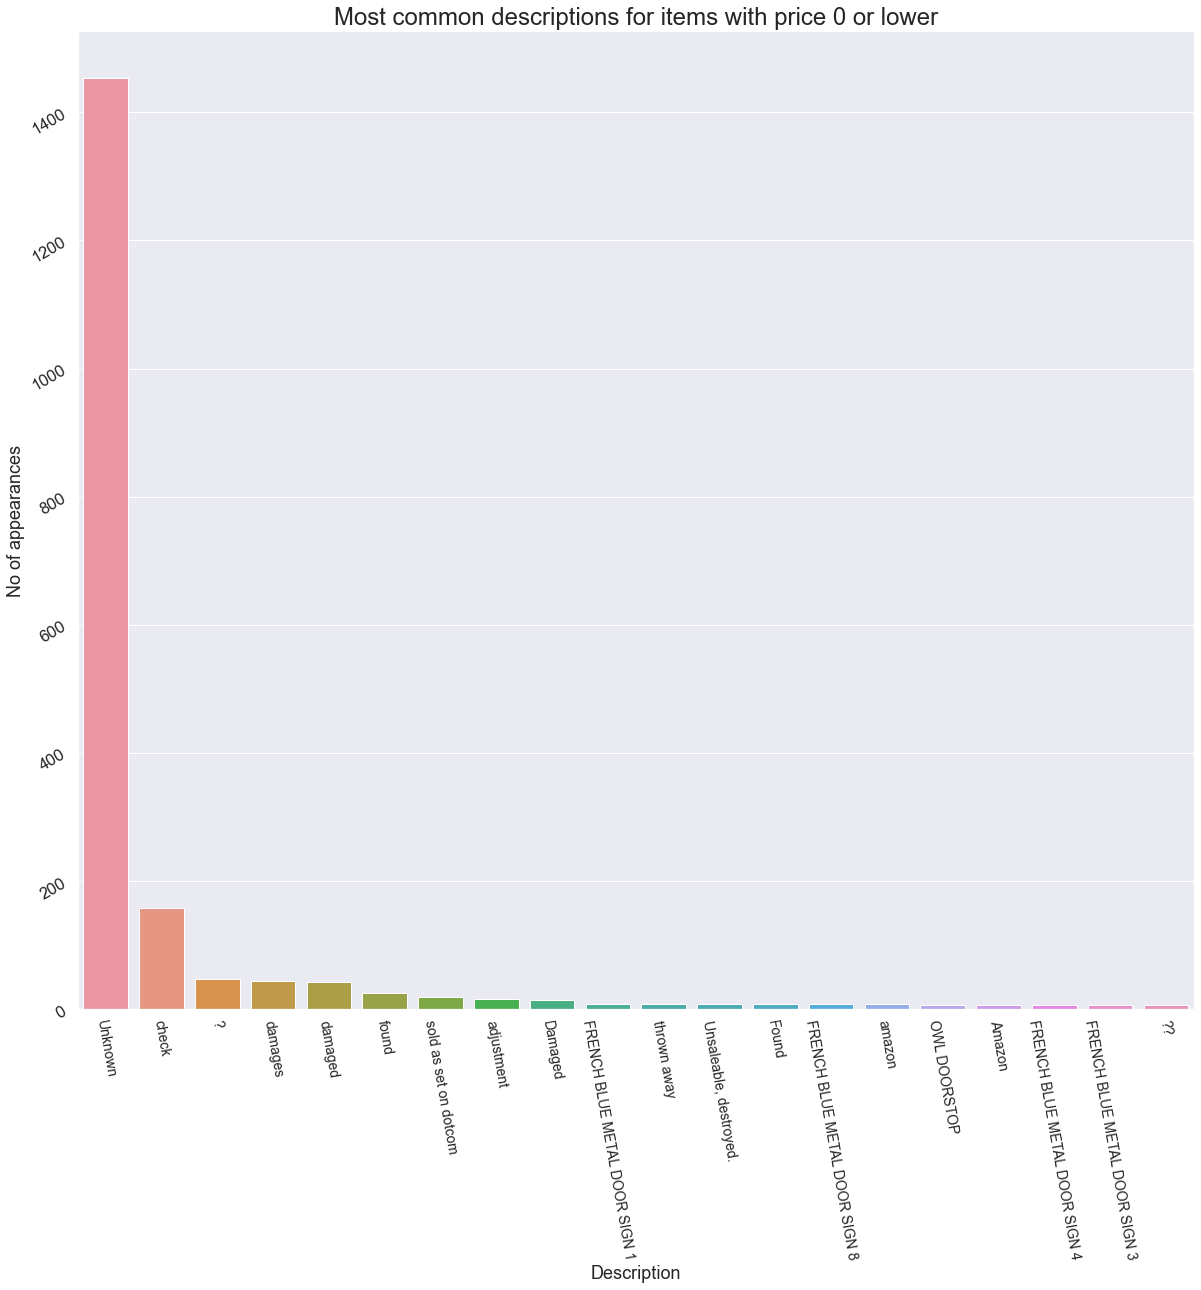

In [21]:
pt =pd.pivot_table(
    odd_items[odd_items['UnitPrice'] <= 0], 
    index='Description', 
    values='InvoiceNo', 
    aggfunc='count').sort_values('InvoiceNo', ascending = False).reset_index()
sns.barplot(data = pt.head(20), x = 'Description', y = 'InvoiceNo')
plt.title('Most common descriptions for items with price 0 or lower', fontsize=24)
plt.xlabel('Description')
plt.ylabel('No of appearances')
plt.yticks(rotation=30)
plt.xticks(rotation=-80, fontsize= 14)
plt.show()

Off the items with price lower than 0, most have descriptions of unknown, damaged or lost. Probably not actual transactions

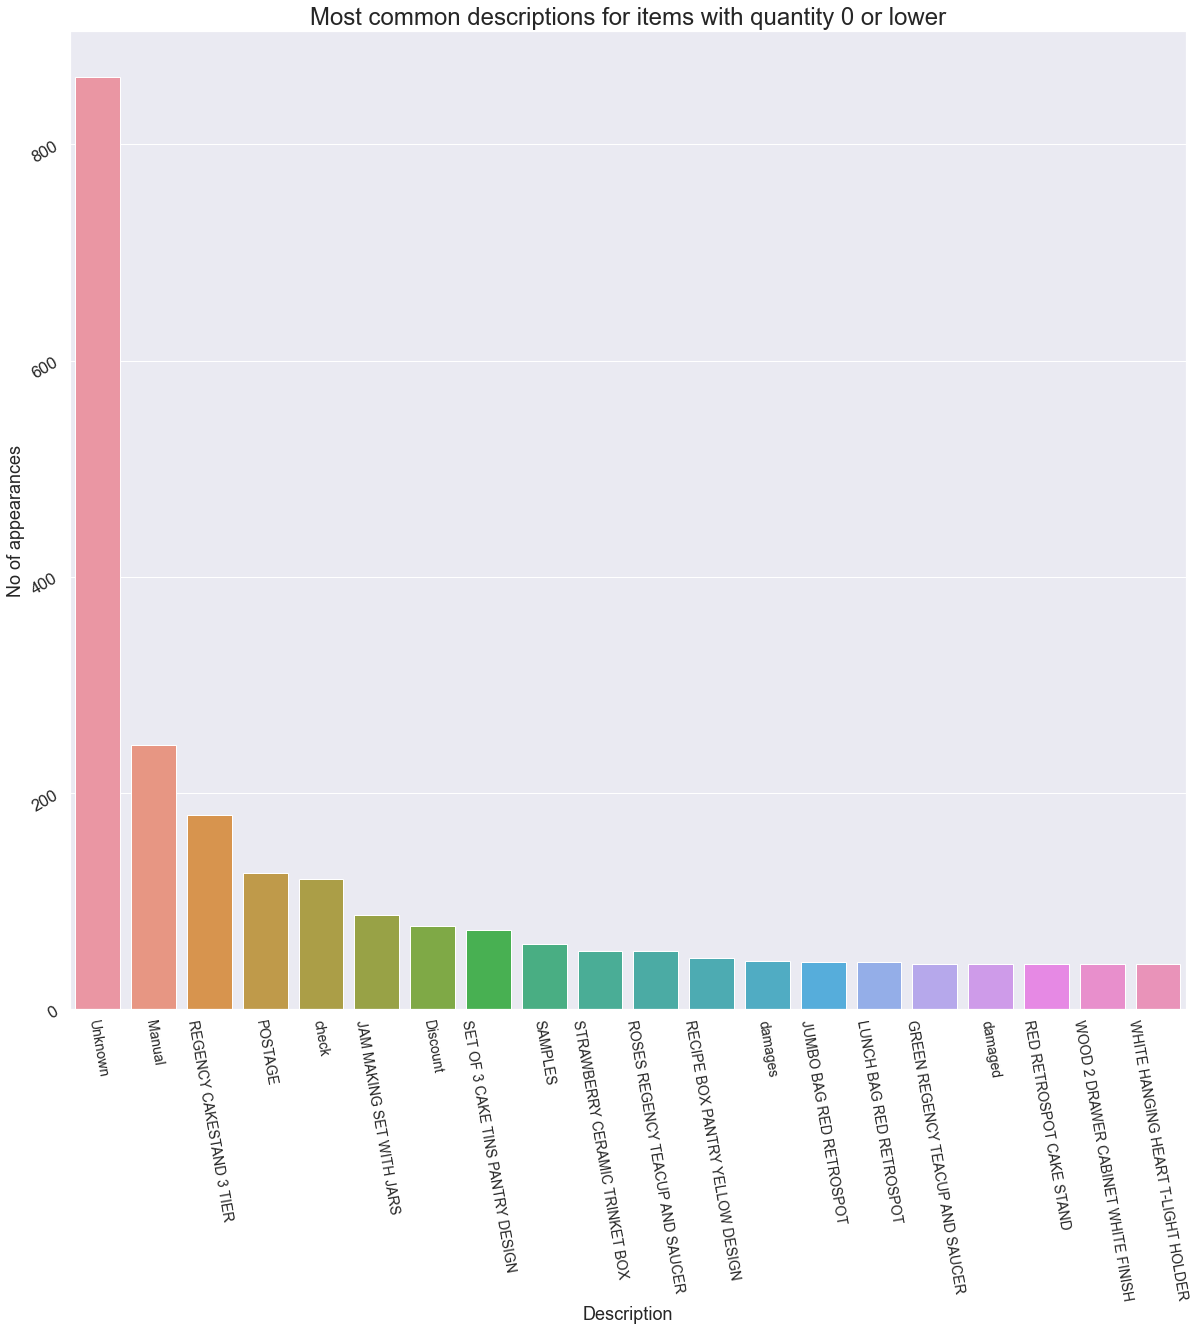

In [22]:
pt1 =pd.pivot_table(
    odd_items[odd_items['Quantity'] <= 0], 
    index='Description', 
    values='InvoiceNo', 
    aggfunc='count').sort_values('InvoiceNo', ascending = False).reset_index()
sns.barplot(data = pt1.head(20), x = 'Description', y = 'InvoiceNo')
plt.title('Most common descriptions for items with quantity 0 or lower', fontsize=24)
plt.xlabel('Description')
plt.ylabel('No of appearances')
plt.yticks(rotation=30)
plt.xticks(rotation=-80, fontsize= 14)
plt.show()

We can see that in many of the cases we talk about returns, damaged items, tests and discounts put in. Many Unknowns. Will be safest to remove them, since we want to investigate the sales and these will put in too many issues.

In [23]:
data = data[(data['UnitPrice'] > 0) & (data['Quantity'] > 0)]

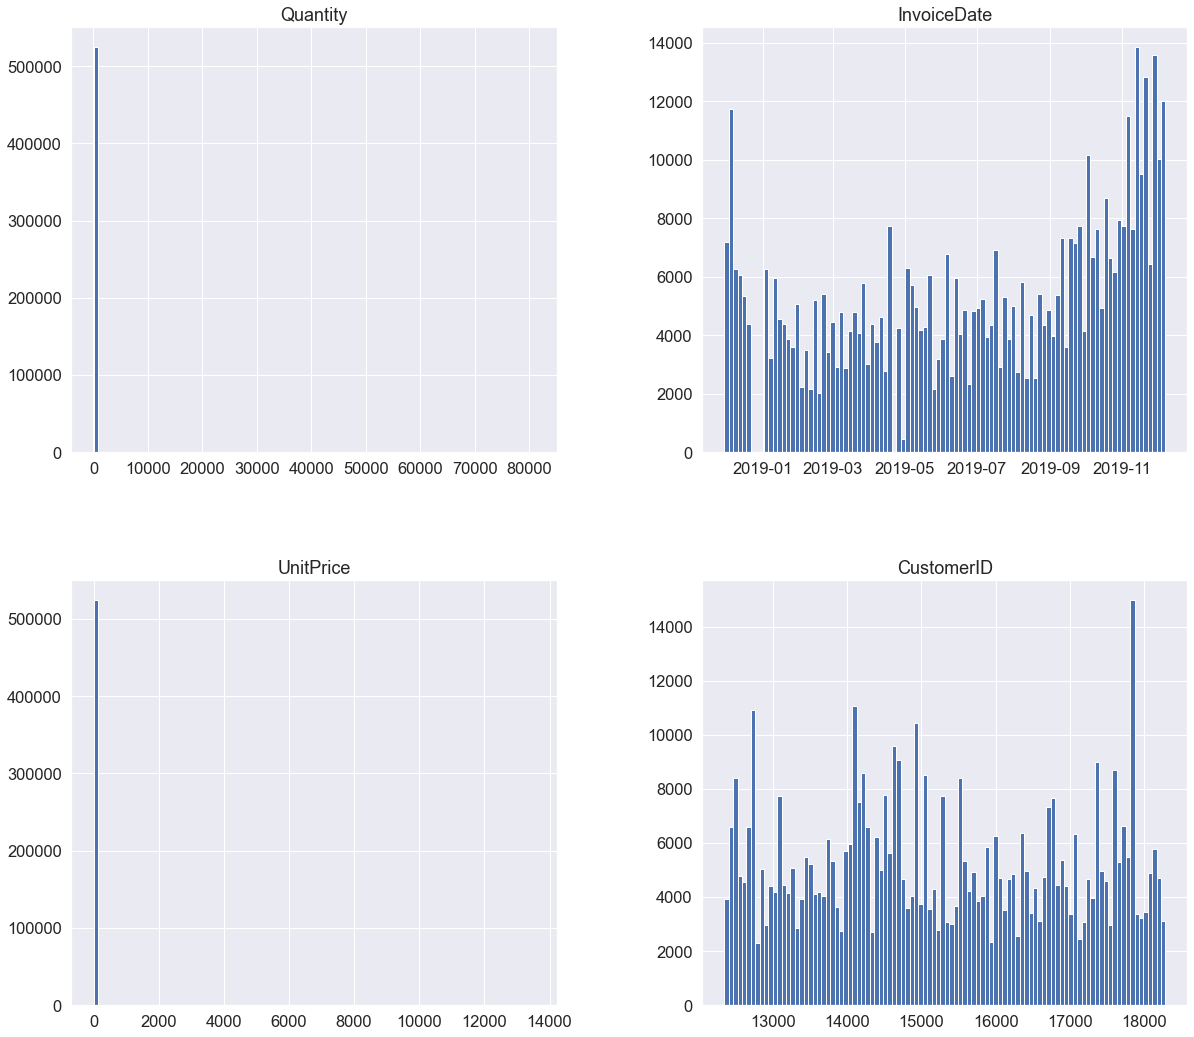

In [24]:
data.hist(bins=100)
plt.show()

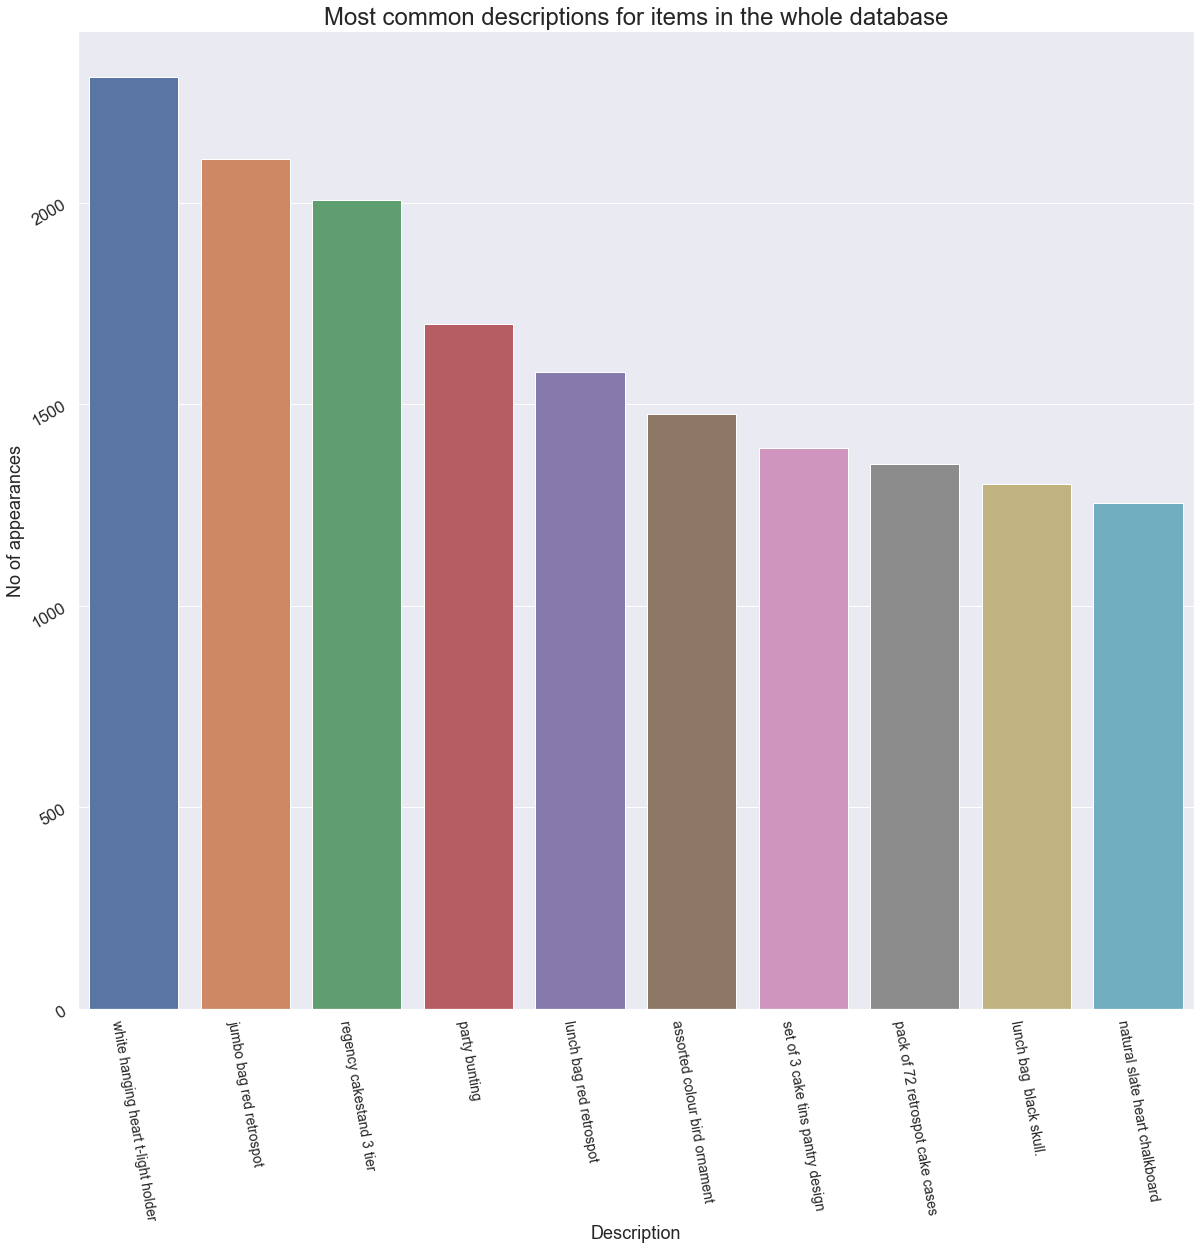

In [25]:
data['Description'] = data['Description'].str.lower()
pt2 = pd.pivot_table(
    data, 
    index='Description', 
    values='InvoiceNo', 
    aggfunc='count').sort_values('InvoiceNo', ascending = False).reset_index()
sns.barplot(data = pt2.head(10), x = 'Description', y = 'InvoiceNo')
plt.title('Most common descriptions for items in the whole database', fontsize=24)
plt.xlabel('Description')
plt.ylabel('No of appearances')
plt.yticks(rotation=30)
plt.xticks(rotation=-80, fontsize= 14)
plt.savefig('1.png')
plt.show()

Here we can see the 10 most common items purchased in the store (According to the log). It's clear that the most common item is white hanging heart t-light holder, followed by jumbo bag red retrospot and regency cakestand 3 tier.

In [26]:
data['Description'] = data['Description'].str.lower()
text = " ".join(description for description in data.Description)

Tokennizing the description to get a list of all keywords with the stopwords. For good measures, as a function.

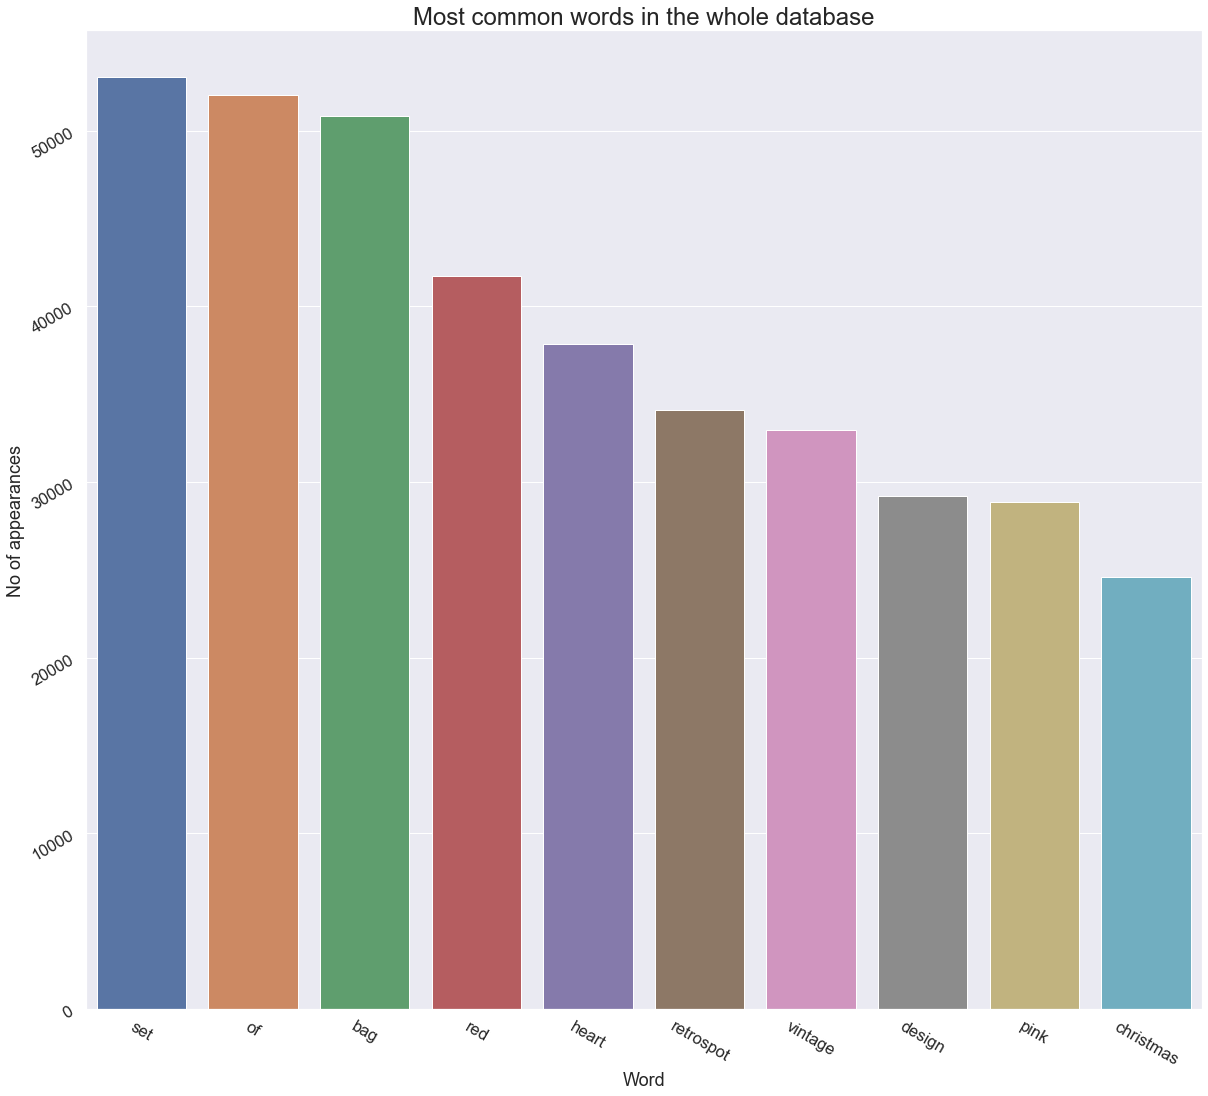

In [27]:
x=Counter(text.split())
x=pd.DataFrame([(l,k) for k,l in sorted([(j,i) for i,j in x.items()], reverse=True)])
x.columns = ['word', 'count']
sns.barplot(data = x.head(10), x = 'word', y = 'count')
plt.title('Most common words in the whole database', fontsize=24)
plt.xlabel('Word')
plt.ylabel('No of appearances')
plt.yticks(rotation=30)
plt.xticks(rotation=-30)
plt.savefig('2.png')
plt.show()

In [28]:
NOW=data['InvoiceDate'].max().date()

In [29]:
data['totalsum'] = data['UnitPrice'] * data['Quantity']
rfm=data.groupby('Description').agg({
    'InvoiceDate': lambda x: (NOW-x.max().date()).days,
    'InvoiceNo': 'count',
    'totalsum':'sum'
}).reset_index()

Creating a column for total sum of each product sold and a knew DF for rfm calculation containing recency (how long has it been since transaction took place), counting how often a transaction took place (frequency) and sum of revenue for each description (item)

In [30]:
rfm.rename(columns={'InvoiceDate':'recency',
                    'InvoiceNo':'frequency',
                   'totalsum':'monetary_value'},inplace=True)

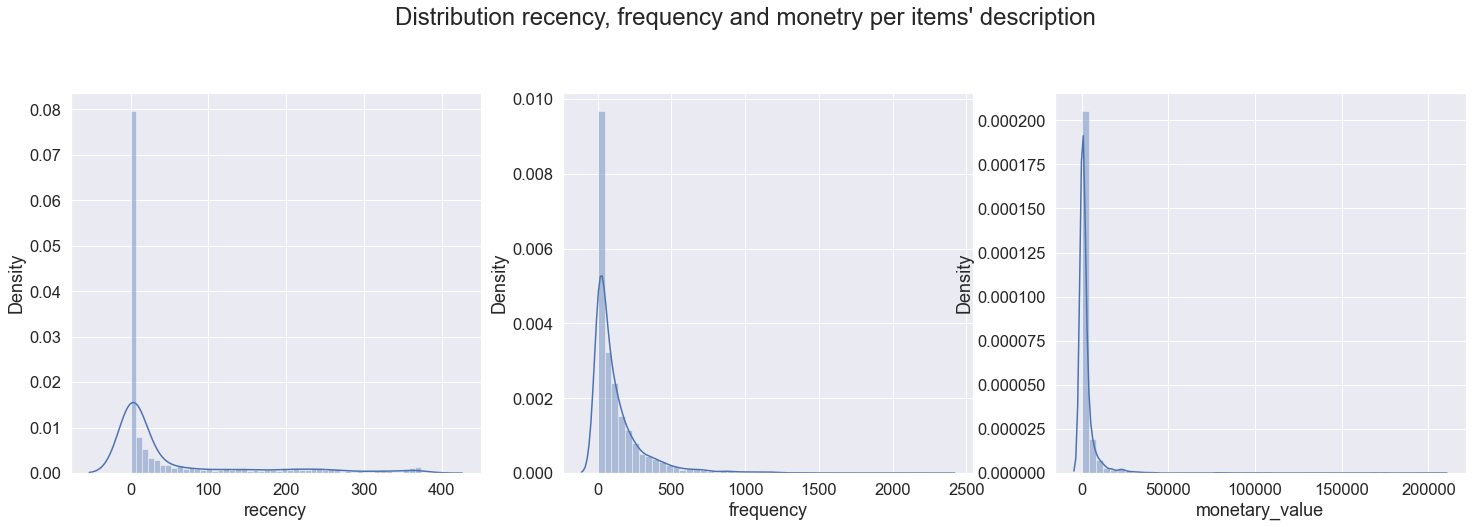

In [31]:
plt.figure(figsize=(25, 7))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Distribution recency, frequency and monetry per items' description",  fontsize=24, y=1.05)
ax1 = plt.subplot(1, 3, 1)
sns.distplot(rfm['recency'])
ax2 = plt.subplot(1, 3, 2)
sns.distplot(rfm['frequency'])
ax3 = plt.subplot(1, 3, 3)
sns.distplot(rfm['monetary_value'])
plt.show()

Distribution is extremely skewed for the all rfm parameters

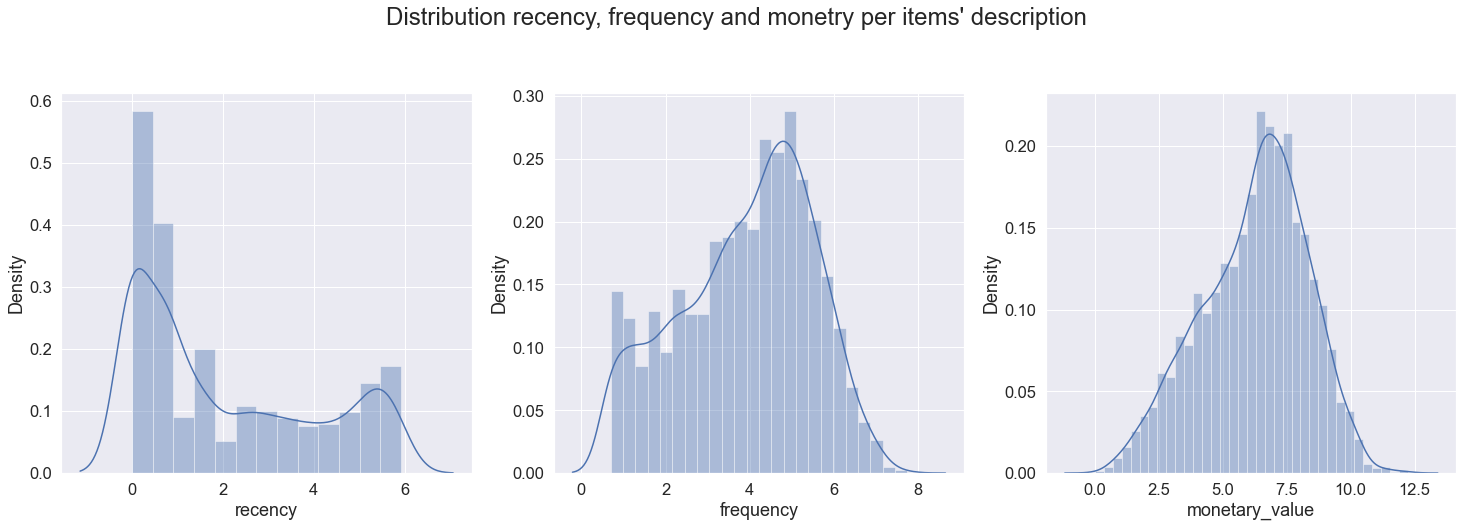

In [32]:
rfm_log = np.log(rfm[['recency', 'frequency', 'monetary_value']]+1)
plt.figure(figsize=(25, 7))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Distribution recency, frequency and monetry per items' description", fontsize=24, y=1.05)
ax1 = plt.subplot(1, 3, 1)
sns.distplot(rfm_log['recency'])
ax2 = plt.subplot(1, 3, 2)
sns.distplot(rfm_log['frequency'])
ax3 = plt.subplot(1, 3, 3)
sns.distplot(rfm_log['monetary_value'])
plt.show()

After applying log transformation, distribution is a lot less skewed

In [33]:
scaler = StandardScaler()
scaler.fit(rfm_log)
RFM_Table_scaled = scaler.transform(rfm_log)
RFM_Table_scaled = pd.DataFrame(RFM_Table_scaled, columns = rfm_log.columns)
RFM_Table_scaled['Description'] = rfm['Description']

Making a new DF with scaled parameters

In [34]:
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(RFM_Table_scaled.drop('Description', axis = 1)) 
    kmeanModel.fit(RFM_Table_scaled.drop('Description', axis = 1))     
      
    distortions.append(sum(np.min(cdist(RFM_Table_scaled.drop('Description', axis = 1), kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / RFM_Table_scaled.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(RFM_Table_scaled.drop('Description', axis = 1), kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / RFM_Table_scaled.shape[0] 
    mapping2[k] = kmeanModel.inertia_

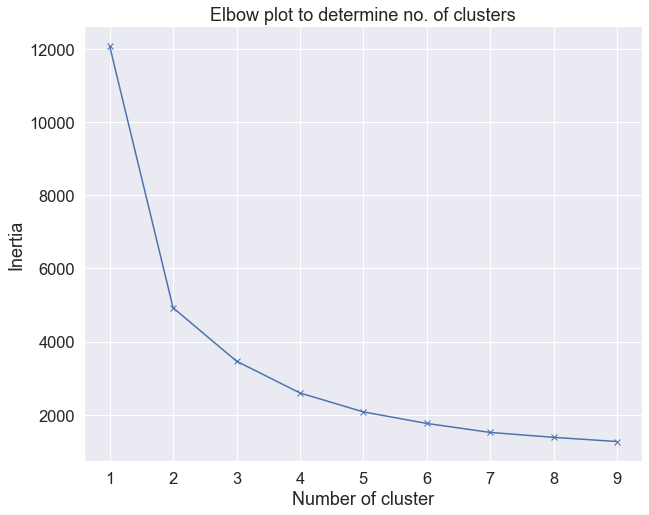

In [35]:
plt.figure(figsize=(10, 8))
plt.plot(K, inertias, 'bx-')
plt.title('Elbow plot to determine no. of clusters')
plt.xlabel('Number of cluster')
plt.ylabel('Inertia')
plt.show()

Assuming an elbow chart to find the amount of clusters needed to segment the data correctly. seems we need anywhere between 3-5 clusters. Will check it closer by applying the model with 3-5 clusters and see how weel the data segments. 

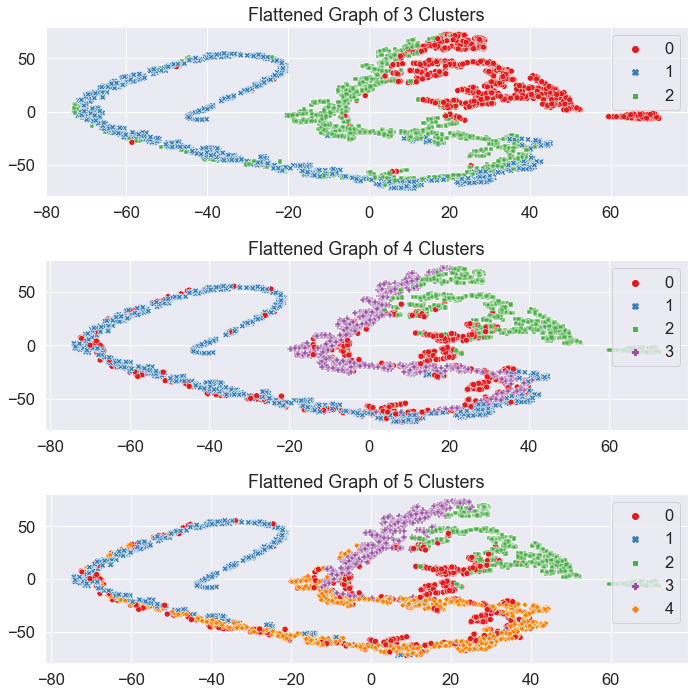

In [36]:
def kmeans(normalised_df_rfm, clusters_number, original_df_rfm):
    
    kmeans = KMeans(n_clusters = clusters_number, random_state = 1)
    kmeans.fit(normalised_df_rfm)
# Extract cluster labels
    cluster_labels = kmeans.labels_
        
    # Create a cluster label column in original dataset
    df_new = original_df_rfm.assign(Cluster = cluster_labels)
    
    # Initialise TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df_new)
    
    # Plot t-SNE
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")
    
    return df_new
plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 1)
df_rfm_k3 = kmeans(RFM_Table_scaled.drop('Description', axis= 1), 3, rfm.drop('Description', axis= 1))
plt.subplot(3, 1, 2)
df_rfm_k4 = kmeans(RFM_Table_scaled.drop('Description', axis= 1), 4, rfm.drop('Description', axis= 1))
plt.subplot(3, 1, 3)
df_rfm_k5 = kmeans(RFM_Table_scaled.drop('Description', axis= 1), 5, rfm.drop('Description', axis= 1))
plt.tight_layout()

From these scatter plots we can see that 4-5 clusters are a bit messy. 3 clusters provide a lot more unique segmentation of the data.

In [37]:
def snake_plot(normalised_df_rfm, df_rfm_k4, df_rfm_original):
    normalised_df_rfm = pd.DataFrame(normalised_df_rfm, 
                                       index=normalised_df_rfm.index, 
                                       columns=normalised_df_rfm.columns)
    normalised_df_rfm['Cluster'] = df_rfm_k4['Cluster'].astype('str')
    df_melt = pd.melt(normalised_df_rfm.reset_index(), 
                        id_vars=pd.Index(set(normalised_df_rfm.columns).difference(set(
                            normalised_df_rfm.select_dtypes(include=(np.number)).columns))),
                        value_vars=list(normalised_df_rfm._get_numeric_data().columns), 
                        var_name='Metric', 
                        value_name='Value')
    plt.xlabel('Metric')
    plt.ylabel('Value')
    sns.pointplot(data=df_melt, x='Metric', y='Value', hue='Cluster')
    
    return

Creating a function that creates snake charts to see how unique each cluster is for 3-5 clusters

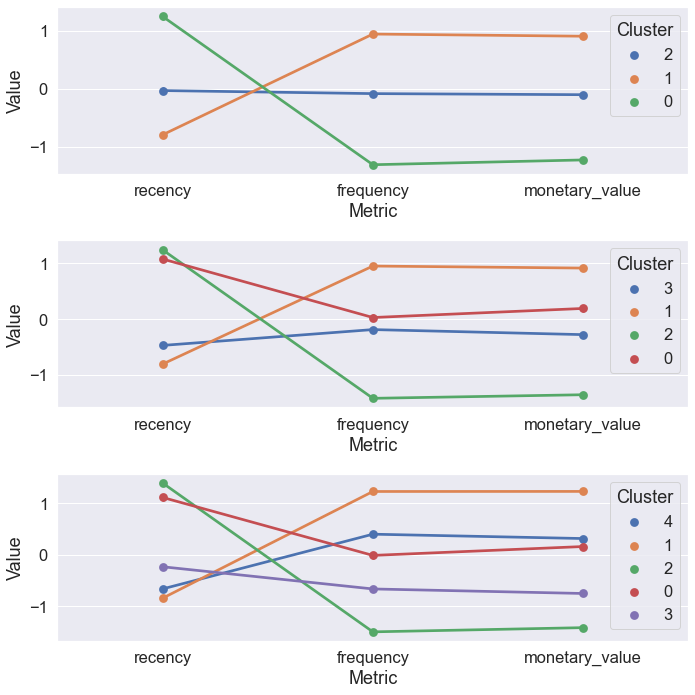

In [38]:
plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 1)
rfm_k3 = snake_plot(RFM_Table_scaled, df_rfm_k3, rfm)
plt.subplot(3, 1, 2)
rfm_k4 = snake_plot(RFM_Table_scaled, df_rfm_k4, rfm)
plt.subplot(3, 1, 3)
rfm_k5 = snake_plot(RFM_Table_scaled, df_rfm_k5, rfm)
plt.tight_layout()


We can see here that 3 clusters provide quite distinct segmentation. 4-5 less so, showing near similarity at recency (and 5 also at monetary).

In [39]:
df_rfm_k3['Description'] = rfm['Description']
def cluster_dis(x):
    if x==0:
        return 'Med'
    elif x==1:
        return 'High'
    else:
        return 'Low'

creating a new function that assigns quality factor to each cluster. Low, in the following case, low rfm score, to High for high rfm score

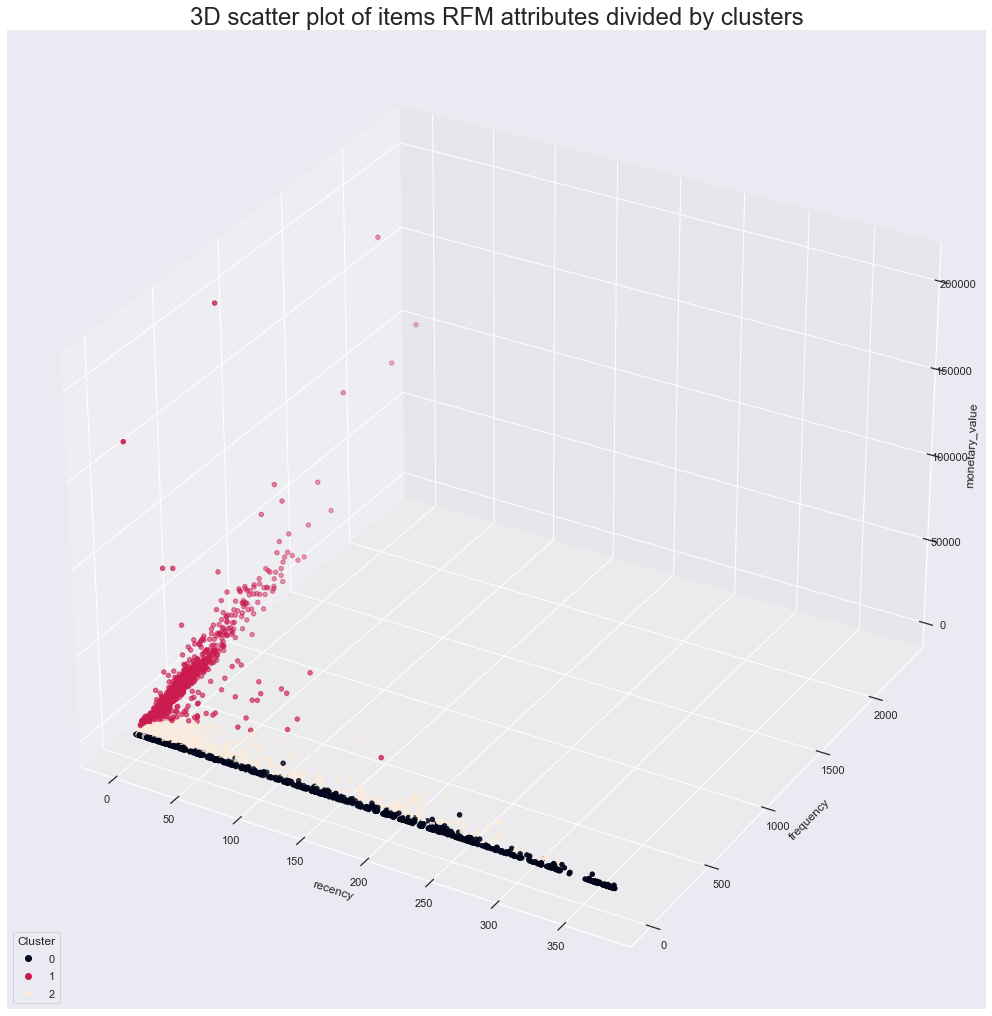

In [40]:
df_rfm_k3['lab'] = df_rfm_k3['Cluster'].apply(cluster_dis) 
sns.set(style = "darkgrid")

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.set_title('3D scatter plot of items RFM attributes divided by clusters', fontsize=24)
ax.set_xlabel('recency')
ax.set_ylabel('frequency')
ax.set_zlabel('monetary_value')
scatter = ax.scatter(df_rfm_k3['recency'], df_rfm_k3['frequency'], df_rfm_k3['monetary_value'], c = df_rfm_k3['Cluster'])
legend = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Cluster")
plt.savefig('3.png')
plt.show()

Plotted the data as a 3D scatter chart. we can see the segmentation between the clusters according to recency, frequency and monetary

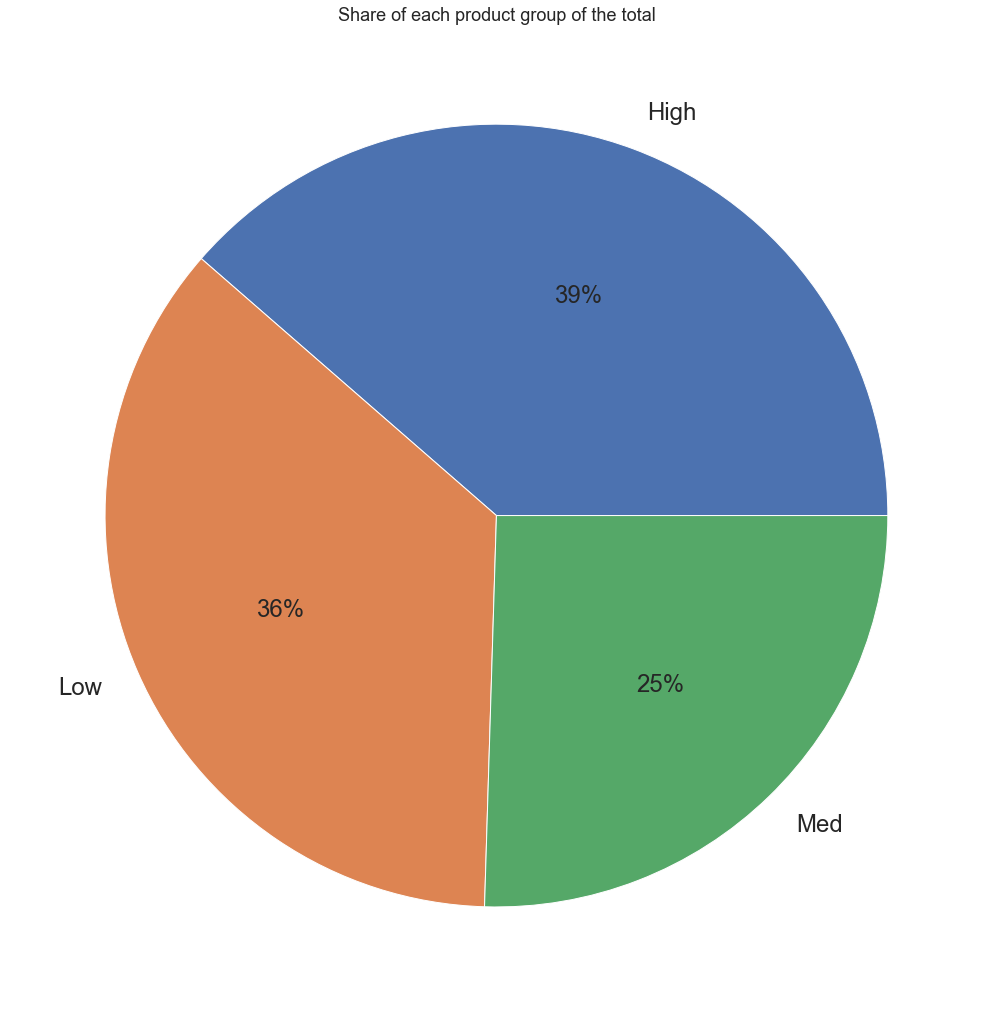

In [41]:
plt.title('Share of each product group of the total', fontsize=18)
plt.pie(df_rfm_k3["Cluster"].value_counts(),
        labels=df_rfm_k3["lab"].value_counts().index,
        autopct='%.0f%%', textprops={'fontsize': 24})
plt.savefig('4.png')
plt.show()

In this pie chart we can see that 36% of the items were assigned as low rfm score, 25% as medium and 39% as high. We have a bit over a 3rd of the items that are not too profitable and a nearly 2/5 of the items that are very profitable.

In [42]:
mylist = ['recency', 'frequency', 'monetary_value']
for a in mylist:
    df_rfm_k3[a+"_T"] = (df_rfm_k3[a]-df_rfm_k3[a].min())/(df_rfm_k3[a].max()-df_rfm_k3[a].min())*9+1

Transforming the r f m to 1-10 scale to allow shared comparison

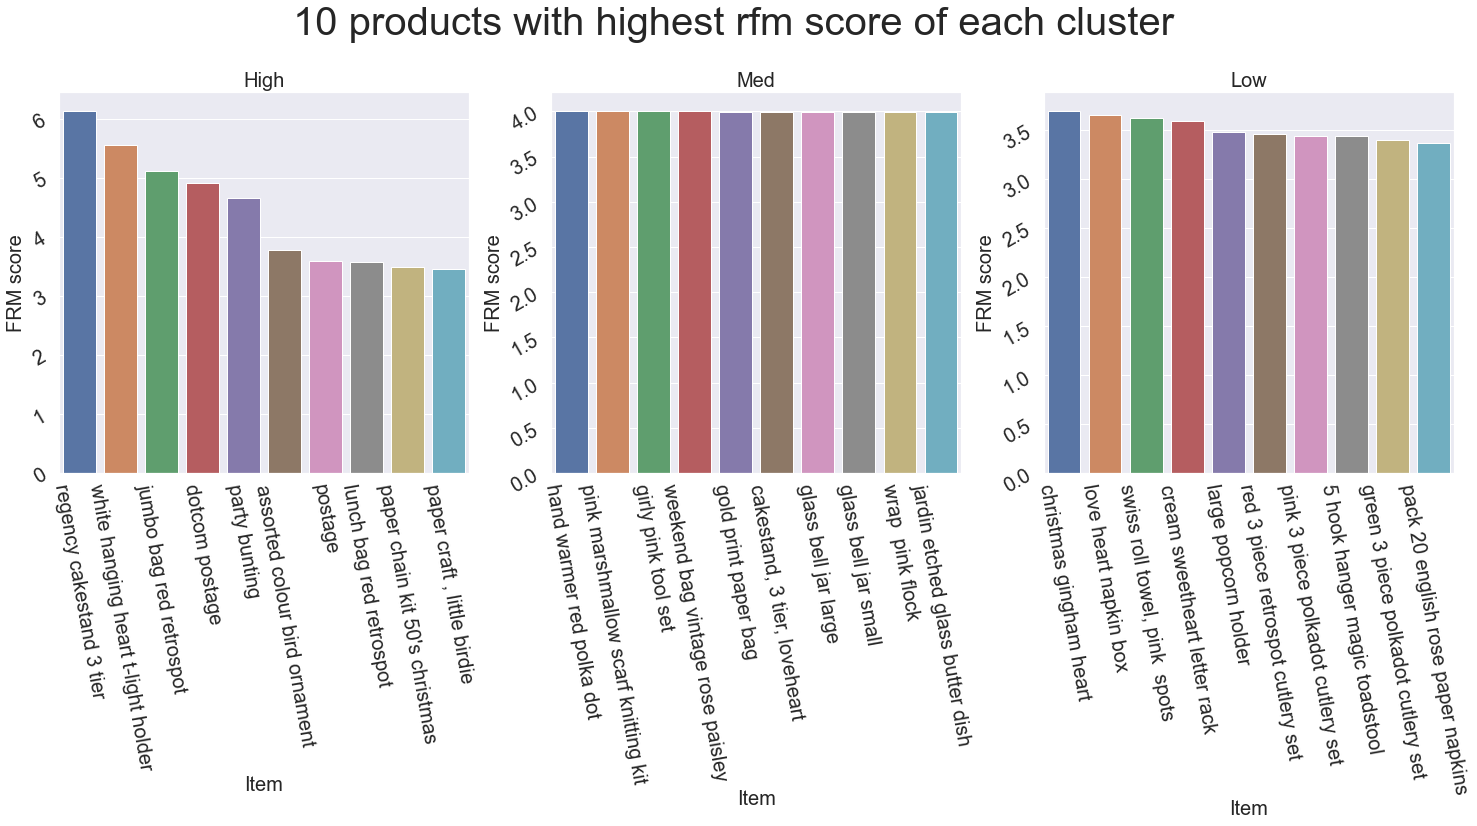

In [43]:
df_rfm_k3['frm_sc'] = df_rfm_k3[['recency_T','frequency_T','monetary_value_T']].mean(axis=1)
mylist = ['High', 'Med', 'Low']
n=1
plt.figure(figsize=(25, 7))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("10 products with highest rfm score of each cluster", fontsize=40, y=1.05)
for i in mylist:
    ax1 = plt.subplot(1, 3, n)
    sns.barplot(data = df_rfm_k3[df_rfm_k3['lab'] == i].sort_values('frm_sc', ascending = False).head(10), 
                x = 'Description', y = 'frm_sc')
    plt.title(i, fontsize=20)
    plt.ylabel('FRM score', fontsize=20)
    plt.xlabel('Item', fontsize=20)
    plt.yticks(rotation=30, fontsize=20)
    plt.xticks(rotation=-80, fontsize=20)
    n=n+1
plt.savefig('5.png')
plt.show()

Here we can see the products with greatest rfm score for each cluster. The products with the greatest rfm score is regency cakestand 3 tier in the high cluster, hand warmer red polkadot in the medium cluster and christmas gingham heart in the low cluster.

In [44]:
invoice = data.groupby(['InvoiceNo']).agg({
    'StockCode' : 'count',
    'Quantity' : 'sum',
    'UnitPrice' : 'sum',
    'Description' : 'sum'
}).reset_index()
invoice.columns = ['InvoiceNo', 'Items', 'Quantity', 'UnitPrice', 'Description']
invoice['variety'] = invoice['Quantity'] / invoice['Items']

creating a new DF to analyse the variety (number of units in total devided bt number of unique items) and the total revenue for each invoice.

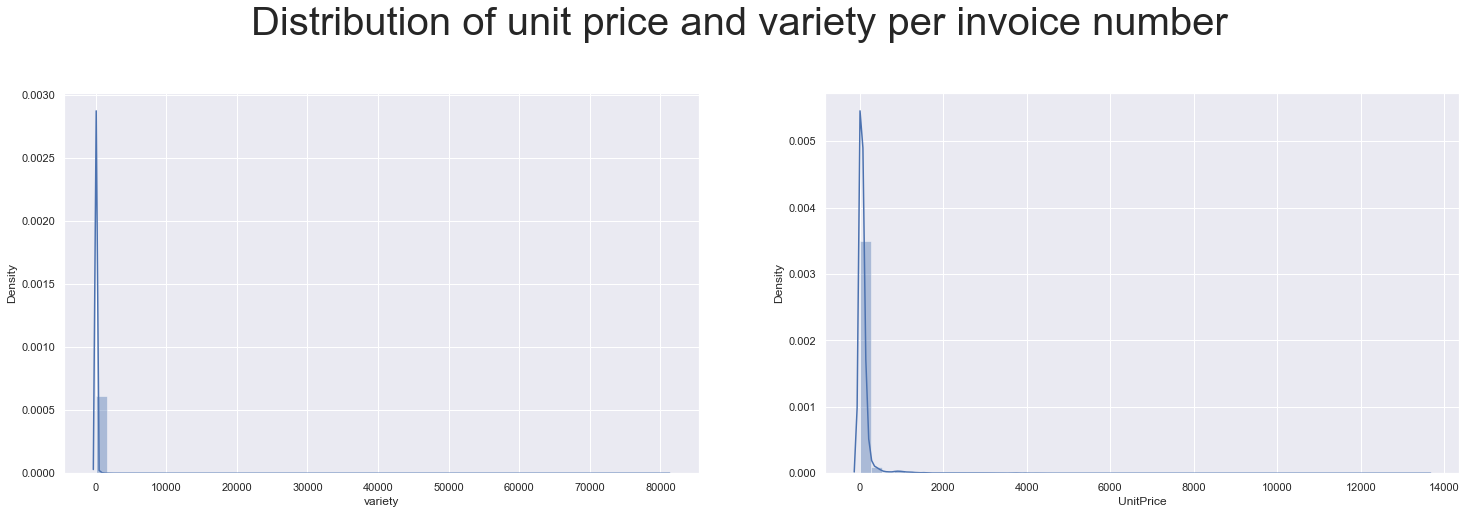

In [45]:
plt.figure(figsize=(25, 7))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Distribution of unit price and variety per invoice number", fontsize=40, y=1.05)
ax1 = plt.subplot(1, 2, 1)
sns.distplot(invoice['variety'])
ax2 = plt.subplot(1, 2, 2)
sns.distplot(invoice['UnitPrice'])
plt.show()

Distribution is extremely skewed again for the variety and UnitPrice. Will require transformation 

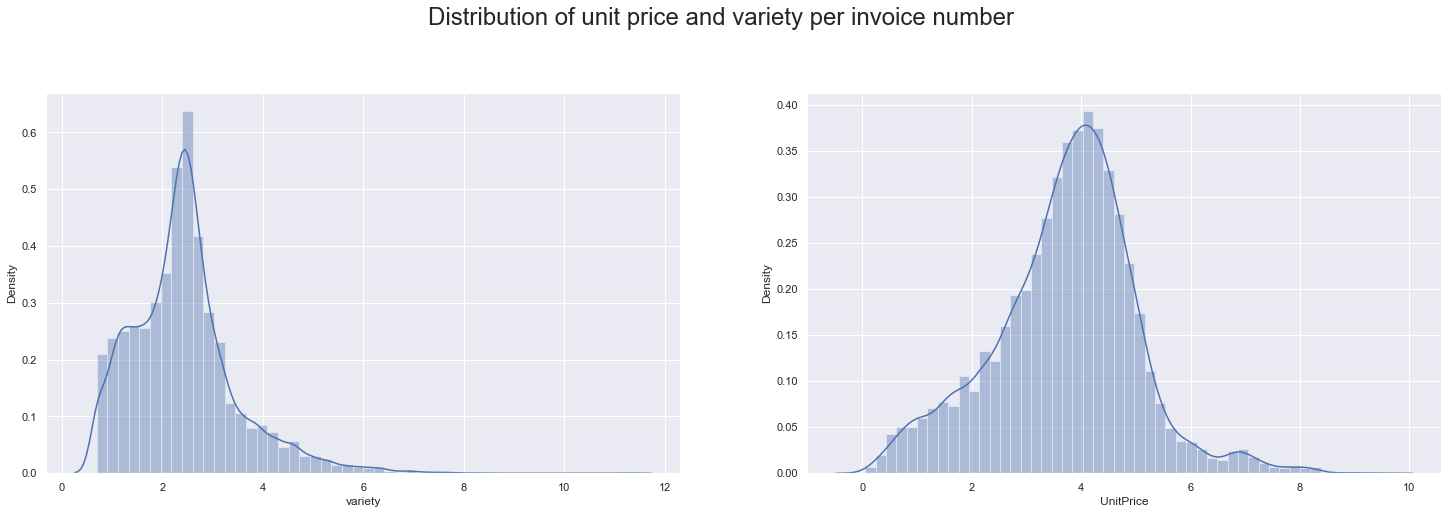

In [46]:
invoice_log = np.log(invoice[['variety', 'UnitPrice']]+1)
plt.figure(figsize=(25, 7))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Distribution of unit price and variety per invoice number",  fontsize=24, y=1.05)
ax1 = plt.subplot(1, 2, 1)
sns.distplot(invoice_log['variety'])
ax2 = plt.subplot(1, 2, 2)
sns.distplot(invoice_log['UnitPrice'])
plt.show()

Looking a lot more normal after log transformation

In [47]:
x_sc = scaler.fit_transform(invoice_log[['variety', 'UnitPrice']])
invoice_scaled = pd.DataFrame(x_sc, columns = invoice_log.columns)
invoice_scaled['InvoiceNo'] = invoice['InvoiceNo']

Making a scaled version of the DF

In [48]:
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(invoice_scaled.drop('InvoiceNo', axis = 1)) 
    kmeanModel.fit(invoice_scaled.drop('InvoiceNo', axis = 1))     
      
    distortions.append(sum(np.min(cdist(invoice_scaled.drop('InvoiceNo', axis = 1), kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / invoice_scaled.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(invoice_scaled.drop('InvoiceNo', axis = 1), kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / invoice_scaled.shape[0] 
    mapping2[k] = kmeanModel.inertia_

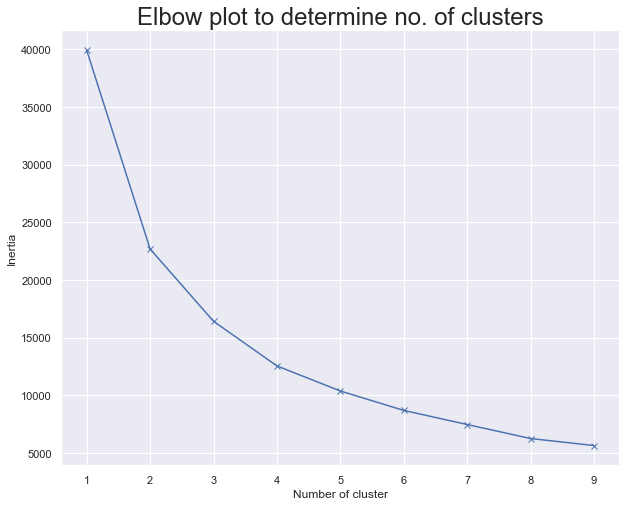

In [49]:
plt.figure(figsize=(10, 8))
plt.plot(K, inertias, 'bx-')
plt.title('Elbow plot to determine no. of clusters', fontsize=24)
plt.xlabel('Number of cluster')
plt.ylabel('Inertia')
plt.show()

Before running a full scale KMeans to categorise our invoices according to their parameters, i try to estimate the number of clusters needed using an elbow chart. The "elbow" of the elbow chart sits between  3-5.

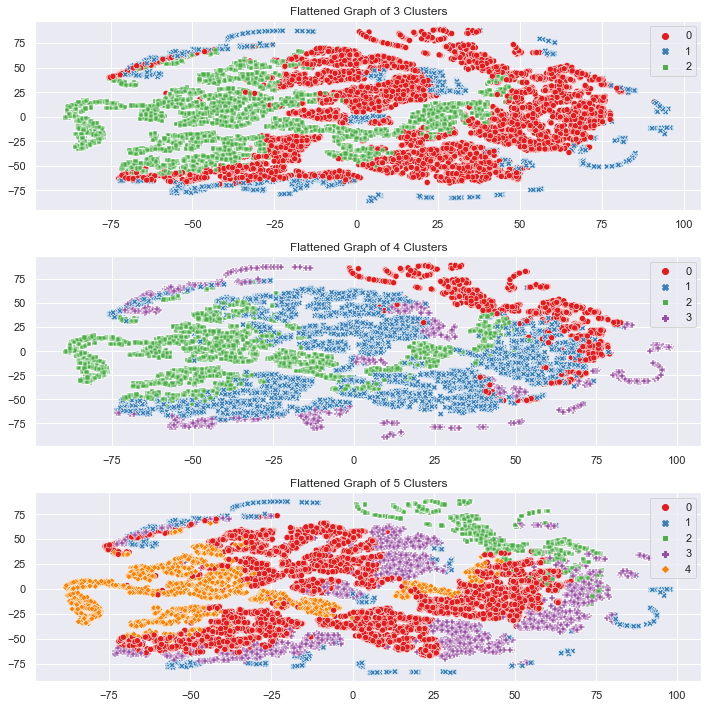

In [50]:
plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 1)
df_invoice_k3 = kmeans(invoice_scaled.drop('InvoiceNo', axis= 1), 3, invoice.drop(['InvoiceNo', 'Description'], axis= 1))
plt.subplot(3, 1, 2)
df_invoice_k4 = kmeans(invoice_scaled.drop('InvoiceNo', axis= 1), 4, invoice.drop(['InvoiceNo', 'Description'], axis= 1))
plt.subplot(3, 1, 3)
df_invoice_k5 = kmeans(invoice_scaled.drop('InvoiceNo', axis= 1), 5, invoice.drop(['InvoiceNo', 'Description'], axis= 1))
plt.tight_layout()

Generally, all 3 options of clustering seem a bit messy. 3 clusters might be better segregated.

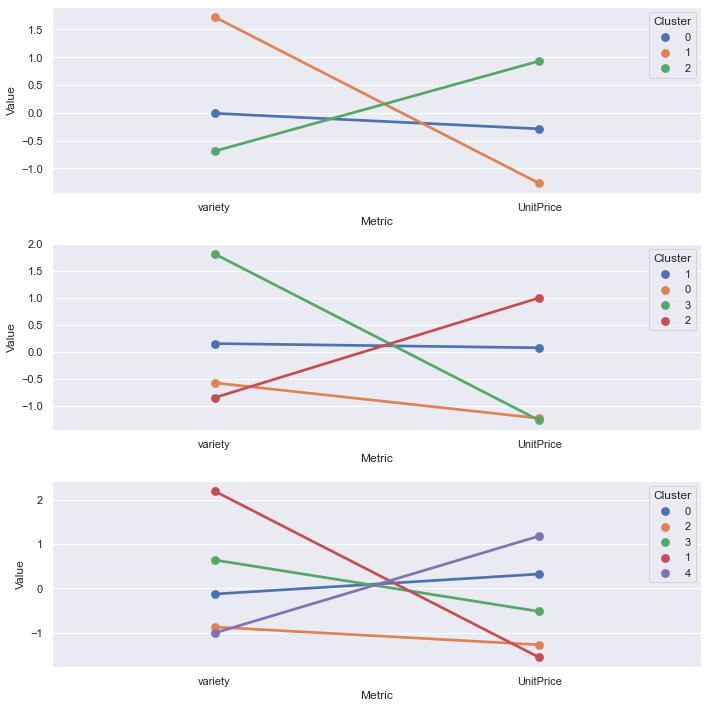

In [51]:
plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 1)
invoice_k3 = snake_plot(invoice_scaled, df_invoice_k3, invoice)
plt.subplot(3, 1, 2)
invoice_k4 = snake_plot(invoice_scaled, df_invoice_k4, invoice)
plt.subplot(3, 1, 3)
invoice_k5 = snake_plot(invoice_scaled, df_invoice_k5, invoice)
plt.tight_layout()

We can see that in the 3 clusters option the cluster better differenciate when checking the snake chart.

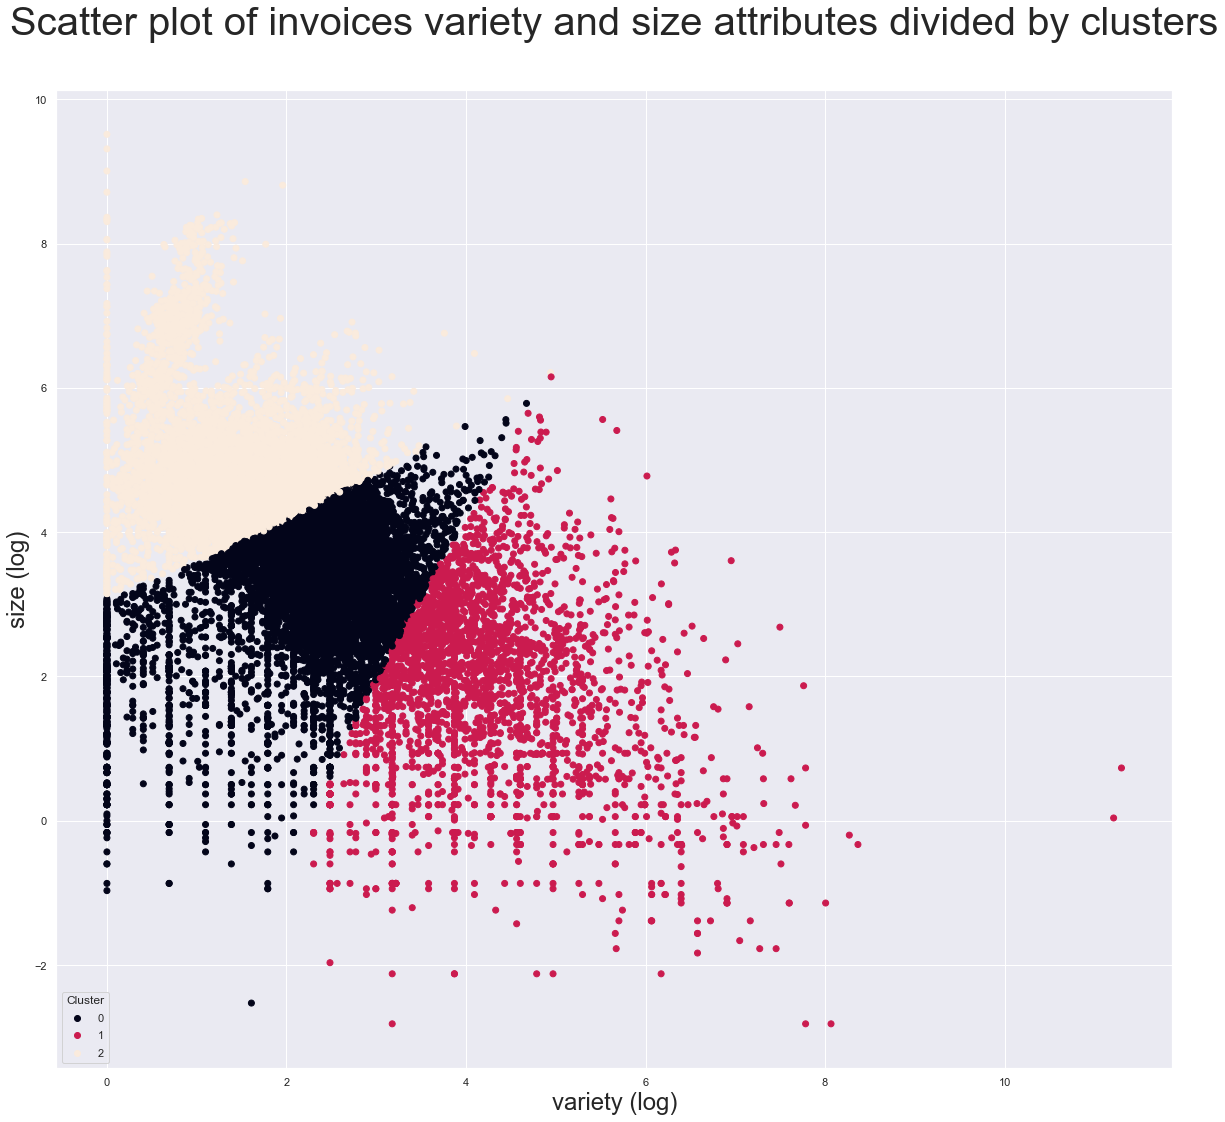

In [52]:
df_invoice_k3['InvoiceNo'] = invoice['InvoiceNo']
df_invoice_k3['lab'] = df_invoice_k3['Cluster'].apply(cluster_dis) 
sns.set(style = "darkgrid")

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('Scatter plot of invoices variety and size attributes divided by clusters', fontsize=40, y=1.05)
ax.set_xlabel('variety (log)', fontsize=24)
ax.set_ylabel('size (log)',  fontsize=24)
scatter = ax.scatter(np.log(df_invoice_k3['variety']), np.log(df_invoice_k3['UnitPrice']), c = df_invoice_k3['Cluster'])
legend = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Cluster")
plt.savefig('6.png')
plt.show()

When looking at the scatter plot of the 3 clusters (after log transformation) we can see good segregation to the clusters. Cluster with greater veriety, but lower size and otherwise. Another mid range cluster in between.|

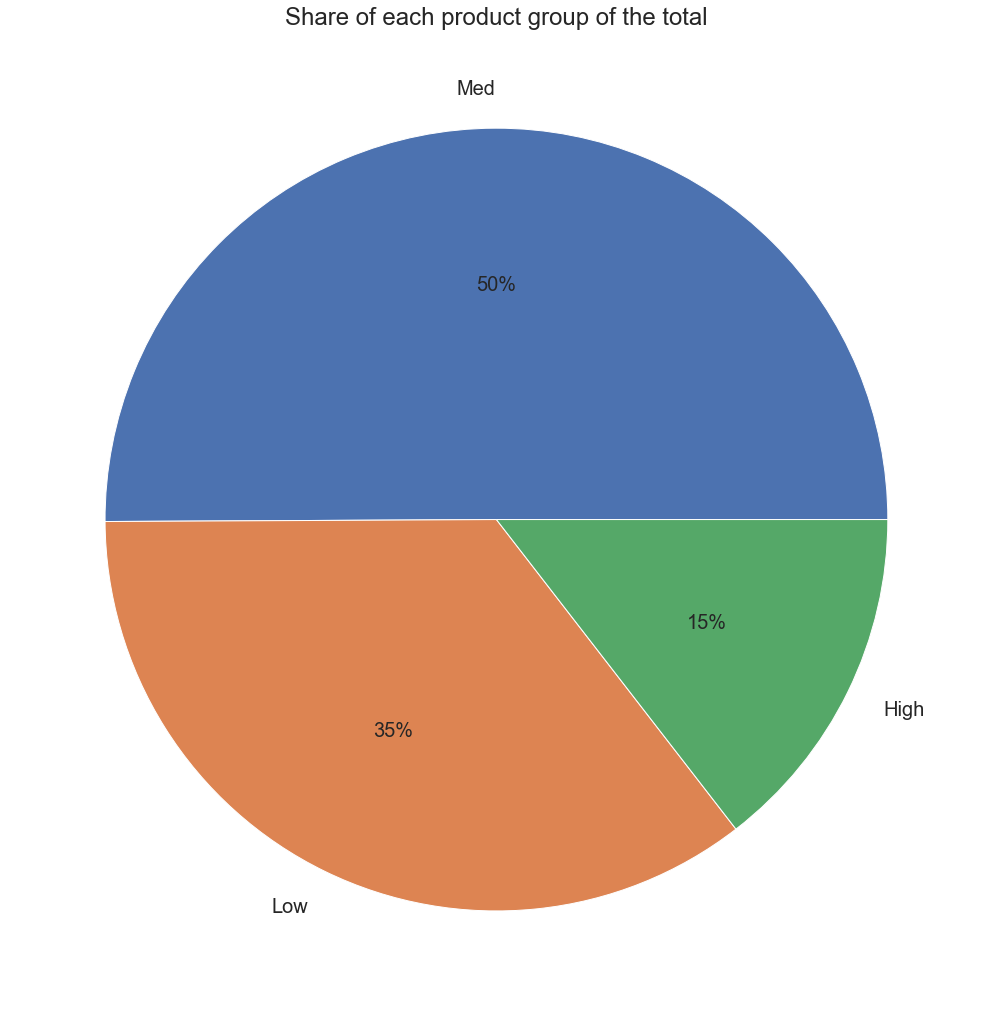

In [53]:
plt.title('Share of each product group of the total', fontsize=24)
plt.pie(df_invoice_k3["Cluster"].value_counts(),
        labels=df_invoice_k3["lab"].value_counts().index,
        autopct='%.0f%%', textprops={'fontsize': 20})
plt.savefig('7.png')
plt.show()

While 50% of the invoices are in the medium range of variety, 15% are in the high and 35% in low.

In [54]:
df_invoice_k3['Description'] = invoice['Description']

Will now check the most common words in each of the 3 clusters, similarly to what I've done before with the whole dataset.

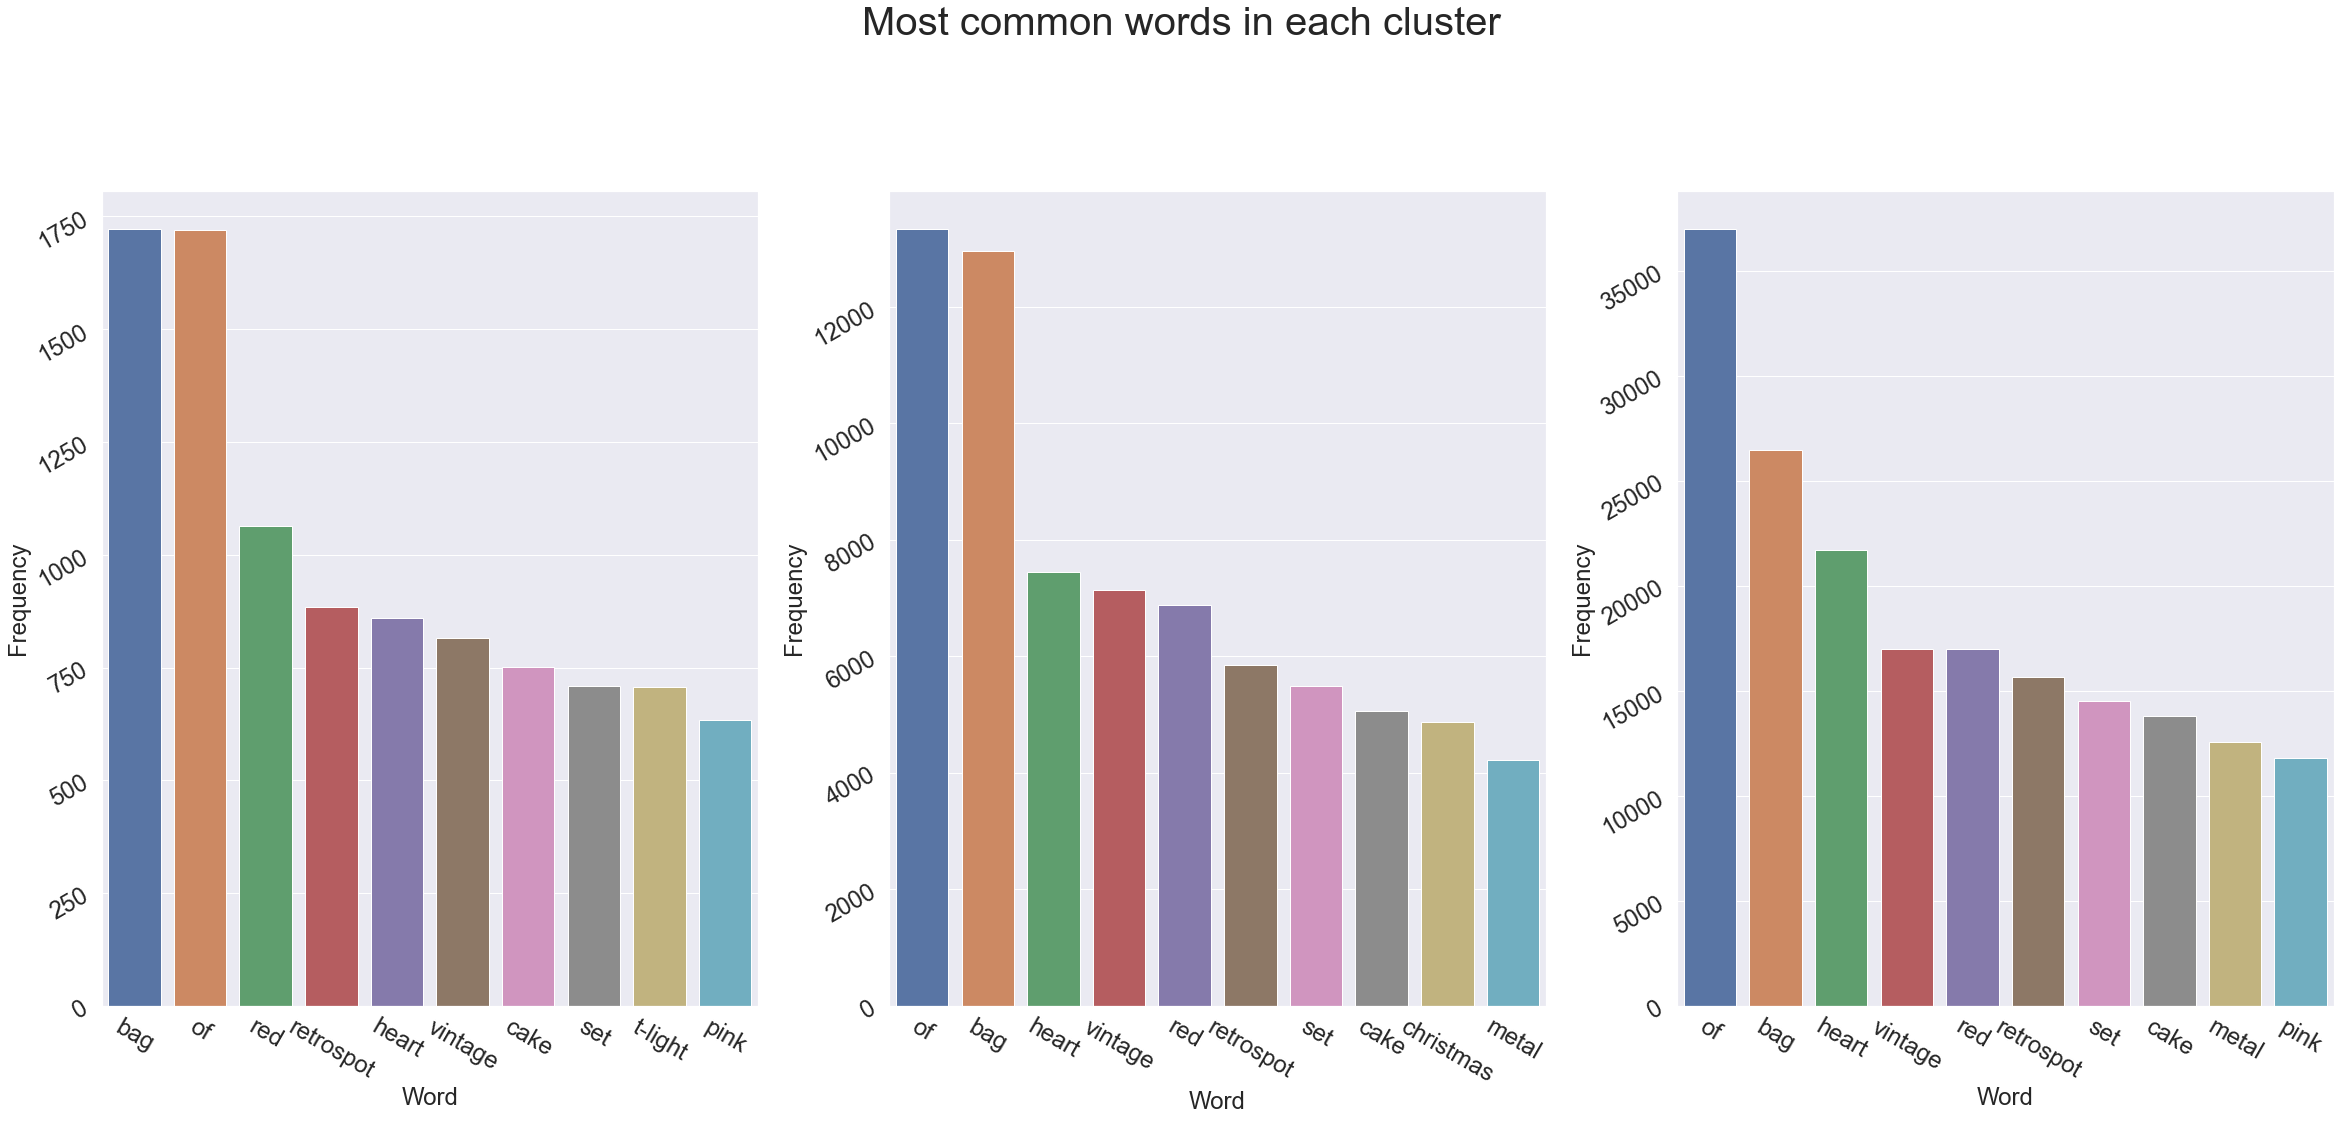

In [55]:
mylist = ['High', 'Med', 'Low']
n=1
plt.figure(figsize=(40, 15))
plt.suptitle("Most common words in each cluster", fontsize=40, y=1.05)
for i in mylist:
    ax1 = plt.subplot(1, 3, n)
    text = " ".join(description for description in df_invoice_k3[df_invoice_k3['lab'] == i]['Description'])
    x=Counter(text.split())
    x=pd.DataFrame([(l,k) for k,l in sorted([(j,i) for i,j in x.items()], reverse=True)])
    x.columns = ['word', 'count']
    sns.barplot(data = x.head(10), x = 'word', y = 'count')
    plt.xlabel('Word', fontsize = 24)
    plt.ylabel('Frequency', fontsize = 24)
    plt.yticks(rotation=30, fontsize = 24)
    plt.xticks(rotation=-30, fontsize = 24)
    n=n+1
plt.savefig('8.png')
plt.show()

We can see that all clusters are dominated bt about the same words- bag, red,retrospot,heart...

I'd like to check if the description's length affects the item's rfm score. For this I'll calculate each item's description length, plot it as as a scetter plot and calculate the correlation between the two.
H0 is that there' is no correlation between the description length and the item's rfm score.
H1 is that there is a significant correlation between the description length and the item's rfm score.

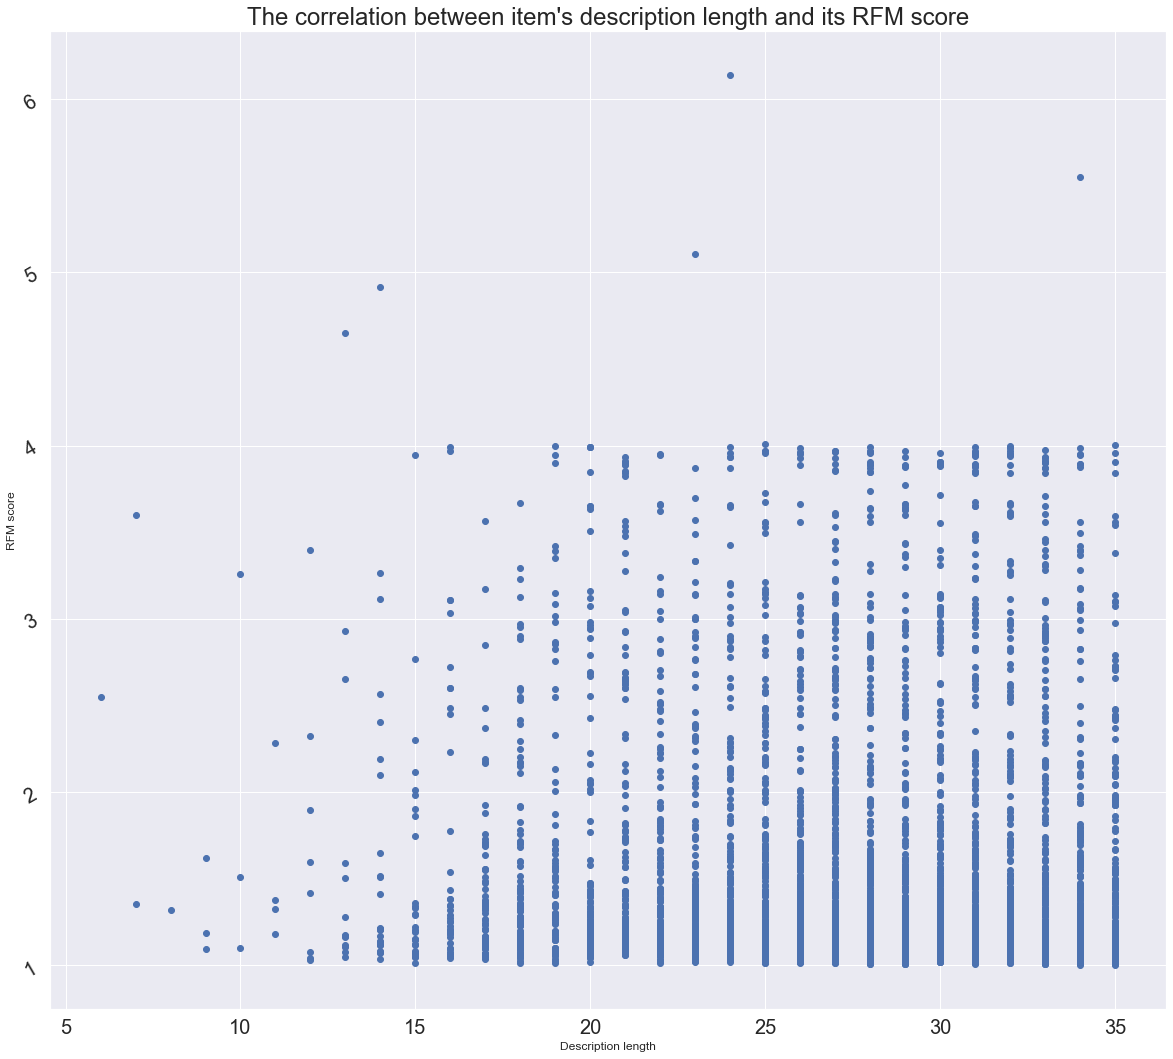

In [56]:
df_rfm_k3['des_len'] = df_rfm_k3['Description'].apply(len)
plt.scatter(df_rfm_k3['des_len'], df_rfm_k3['frm_sc'])
plt.title("The correlation between item's description length and its RFM score", fontsize=24)
plt.ylabel('RFM score')
plt.xlabel('Description length')
plt.yticks(rotation=30, fontsize=20)
plt.xticks(fontsize=20)
plt.savefig('9.png')
plt.show()

The scatter plot already shows a mixed bag here. Can't tell if there's any specific correlation.

In [57]:
def normality(col):
    k2, p = st.shapiro(col)
    alpha = 0.05
    print("for {:s} p = {:g}".format(col.name, p))
    if p < alpha: 
        print("The null hypothesis can be rejected- distribution isn't normal")
    else:
        print("The null hypothesis cannot be rejected- normal distribution")

Need to check if the data is distributed normaly to see what correlation I can user parametric or non parametric. H0 is that both datasets distributed normally and H1 is that they don't.

In [58]:
normality(df_rfm_k3['des_len'])
normality(df_rfm_k3['frm_sc'])

for des_len p = 1.1821e-30
The null hypothesis can be rejected- distribution isn't normal
for frm_sc p = 0
The null hypothesis can be rejected- distribution isn't normal


They don't distribute normally, so I'm going to apply spearman's non-parametric correlation test.

In [59]:
corr, p = spearmanr(df_rfm_k3['des_len'], df_rfm_k3['frm_sc'])
print('Spearman correlation: %.3f' % corr, 'and p: %g' % p)

Spearman correlation: -0.020 and p: 0.199395


Correlation is wasn't found significant and the r is almost 0, so can't say there's an actual effect of the description length and the rfm score.

# Conclusions
It's clear that the most common items on the invoices are "white hanging heart t-light holder", followed by "jumbo bag red retrospot" and "regency cakestand 3 tier". Most common words were "set", "bag" and "red". We sow that when clculating each item's RFM we can divide the dataset to 3 unique groups. About 39% of the items in the shop have high rf, score, which ,eans that we better look into them and stock more on these items. The list includes "regency cakestand 3 tier", "white hangin heart t-light holder", "jumbo bag red retrospot" and more (a full list can be easily provided).
In addition, we sow that invoices (purchases) that had high variety (high ratio no. of items / unique items), tended to be lower in size (revenue). We can see, on the other hand, that lower variety brought to larger revenue. We should focus on customers who buy in stocks. They're a great income. Couldn't find a noteable difference between the groups of invoices as to the composition of words. Seems like we're getting the same dominating words across the board. 
Also, I've found no significant correlation between the length of the description of an item and its performance (rfm score). This leads me to believe the customers buy according to their needs and not looking for the descriptions, or at least aren't deterred by them.

To dashboard:
https://public.tableau.com/app/profile/jonathan.levanoni/viz/finalproject_16499899609330/Dashboard2?publish=yes

To presentation: https://drive.google.com/file/d/1ZPyumIX_ATV1rQTayBVYXy2gjD_L4Sqo/view?usp=sharing

Sources: 
* https://www.datacamp.com/community/tutorials/wordcloud-python
* https://medium.com/web-mining-is688-spring-2021/using-k-means-to-segment-customers-based-on-rfm-variables-9d4d683688c8
* https://realpython.com/k-means-clustering-python/
* https://www.geeksforgeeks.org/python-lemmatization-with-nltk/
* https://www.statology.org/shapiro-wilk-test-python/
* https://machinelearningmastery.com/how-to-use-correlation-to-understand-the-relationship-between-variables/